<a href="https://colab.research.google.com/github/timthedev07/emotion-classification/blob/dev/emotion_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Update tensorflow.

In [ ]:
!pip uninstall tensorflow -y
!pip install tensorflow==2.9.1

Import libraries.

In [ ]:
import os
import string
import re
import pandas as pd
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D, Dropout, LSTM, Conv1D
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.callbacks import EarlyStopping
import nltk
import numpy as np
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from google.colab import drive
drive.mount('/content/gdrive')

nltk.download('stopwords')
stopWords = set(stopwords.words("english"))
stopWords.remove("not")

Load the dataset.

In [ ]:
!rm -rf ./sample_data
!rm -rf ./data
!mkdir data

!cp "/content/gdrive/My Drive/datasets/emotion-classification/train.txt.zip" data
!cp "/content/gdrive/My Drive/datasets/emotion-classification/test.txt.zip" data
!cp "/content/gdrive/My Drive/datasets/emotion-classification/validation.txt.zip" data
%cd data
!unzip -ojq "*.txt.zip"
!rm -rf *.txt.zip
%cd ..

Text cleaning.

In [3]:
def customStandardization(text: tf.Tensor):
    # to lower case
    text = tf.strings.lower(text)
    # expand contraction
    pairs = [
        ("won't", "will not"),
        ("can't", "can not"),
        ("n't", " not"),
        ("'re", " are"),
        ("'s", " is"),
        ("'d", " would"),
        ("'ll", " will"),
        ("'t", " not"),
        ("'ve", " have"),
        ("'m", " am"),
    ]
    for contracted, replacement in pairs:
        text = tf.strings.regex_replace(text, contracted, replacement)
    
    # clean special symbols
    text = tf.strings.regex_replace(text, r"\d+(?:\.\d*)?(?:[eE][+-]?\d+)?", " ")
    text = tf.strings.regex_replace(text, r"[^A-Za-z0-9]+", " ")

    # remove stopwords
    for i in stopWords:
        text = tf.strings.regex_replace(text, f"[^A-Za-z0-9_]+{i}[^A-Za-z0-9_]+", " ")

    return text

Load the dataset

In [4]:
DATA_DIR = "data"
COLUMNS = ["text", "label"]

def loadDataset(dataset = "train"):
    """
    `dataset` => "train" | "test" | "validation"
    """
    fileName = os.path.join(DATA_DIR, dataset + ".txt")

    with open(fileName, "r", encoding = "utf-8") as f:
        lines = f.readlines()

        rows = []
        for line in lines:
            line = line.strip("\n")
            [text, label] = line.split(";")

            rows.append({
                "text": text,
                "label": label,
            })
        
        return pd.DataFrame(rows, columns = COLUMNS)

train = loadDataset()
test = loadDataset("test")
validation = loadDataset("validation")

# collect labels
LABELS = np.sort(train["label"].unique())

# x datasets
trainX, validationX, testX = train["text"], validation["text"], test["text"]

# y datasets, one-hot encoded
trainY = pd.get_dummies(train["label"])
validationY = pd.get_dummies(validation["label"])
testY = pd.get_dummies(test["label"])


RNN with LSTM.

In [5]:
VOCAB_SIZE = 20000
SEQUENCE_LENGTH = 64
EMBEDDING_DIM = 32

vectorizeLayer = TextVectorization(
    max_tokens = VOCAB_SIZE,
    standardize = customStandardization,
    output_mode = "int",
    output_sequence_length = SEQUENCE_LENGTH
)

vectorizeLayer.adapt(np.concatenate([trainX, validationX, testX]))

In [6]:
embeddingLayer = Embedding(VOCAB_SIZE, EMBEDDING_DIM, name="embedding_layer")
outputLayer = Dense(len(LABELS), activation = "softmax")

cnn = Sequential([
    vectorizeLayer,
    embeddingLayer,

    Conv1D(filters=32, kernel_size=4, activation='relu'),
    GlobalAveragePooling1D(),
    Dense(16),
    Dropout(0.4),
    Dense(16),
    Dropout(0.4),

    outputLayer
], name="CNN_emotion_classification")
cnn.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

cnn.summary()


Model: "CNN_emotion_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 64)               0         
 torization)                                                     
                                                                 
 embedding_layer (Embedding)  (None, 64, 32)           640000    
                                                                 
 conv1d (Conv1D)             (None, 61, 32)            4128      
                                                                 
 global_average_pooling1d (G  (None, 32)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dropout (Dropout)           (None, 16) 

Now let's train the model.

In [7]:
EPOCHS = 20

callback = EarlyStopping(patience = 3)

cnn.fit(
    trainX,
    trainY,
    validation_data = (validationX, validationY),
    batch_size = 32,
    callbacks = [callback],
    epochs = EPOCHS,
)

Epoch 1/20
500/500 [==============================] - 10s 18ms/step - loss: 0.4407 - accuracy: 0.3108 - val_loss: 0.3850 - val_accuracy: 0.3535
Epoch 2/20
500/500 [==============================] - 8s 17ms/step - loss: 0.3640 - accuracy: 0.3911 - val_loss: 0.3307 - val_accuracy: 0.4785
Epoch 3/20
500/500 [==============================] - 9s 17ms/step - loss: 0.3315 - accuracy: 0.4649 - val_loss: 0.3121 - val_accuracy: 0.5105
Epoch 4/20
500/500 [==============================] - 8s 17ms/step - loss: 0.2945 - accuracy: 0.6062 - val_loss: 0.2820 - val_accuracy: 0.6575
Epoch 5/20
500/500 [==============================] - 9s 18ms/step - loss: 0.2370 - accuracy: 0.7071 - val_loss: 0.2122 - val_accuracy: 0.7245
Epoch 6/20
500/500 [==============================] - 10s 20ms/step - loss: 0.1837 - accuracy: 0.7906 - val_loss: 0.1898 - val_accuracy: 0.8100
Epoch 7/20
500/500 [==============================] - 9s 18ms/step - loss: 0.1575 - accuracy: 0.8430 - val_loss: 0.1816 - val_accuracy: 0.83

In [8]:
print("CNN's performance on test data:")
cnn.evaluate(testX, testY, batch_size = 64)

CNN's performance on test data:
32/32 [==============================] - 0s 13ms/step - loss: 0.1880 - accuracy: 0.8560


[0.1879863739013672, 0.8560000061988831]

Save the model.

In [15]:
cnn.save("model")
# compress model
!zip -r model.zip model

# download model
from google.colab import files
files.download("model.zip")

  adding: model/ (stored 0%)
  adding: model/saved_model.pb (deflated 81%)
  adding: model/assets/ (stored 0%)
  adding: model/variables/ (stored 0%)
  adding: model/variables/variables.index (deflated 64%)
  adding: model/variables/variables.data-00000-of-00001 (deflated 20%)
  adding: model/keras_metadata.pb (deflated 89%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Inference.

In [13]:
from matplotlib import pyplot as plt

def plotDist(probabilityDistribution):
    plt.bar(LABELS, probabilityDistribution)    

1/1 [==============================] - 0s 307ms/step


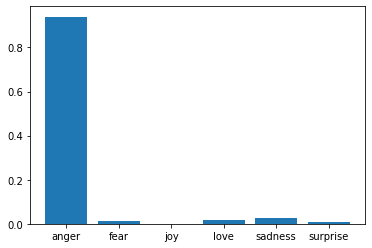

In [14]:
custom_objects = {"customStandardization": customStandardization}
with tf.keras.utils.custom_object_scope(custom_objects):
    loaded = tf.keras.models.load_model("model")
    [res] = loaded.predict(["I'm fucked up, shit."])
    plotDist(res)